# Capstone Project of the Machine Learning Engineer Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Logo Detection App

---
### Why We're Here 

In this notebook, we make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, our code will accept any user-supplied image as input.  If a logo is detected in the image, it will provide an estimate of the brand.  

![Sample Logo Output](samples.jpg)

In this real-world setting, we need to piece together a series of models to perform different tasks; for instance, the algorithm that detects logos in an image will be different from the CNN that infers the brand.  

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Logos
* [Step 3](#step2): Create a CNN to Classify Brands (from Scratch)
* [Step 4](#step3): Use a CNN to Classify Brands (using Transfer Learning)
* [Step 5](#step4): Create a CNN to Classify Brands (using Transfer Learning)
* [Step 6](#step5): Write the Algorithm
* [Step 7](#step6): Test the Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Logo in the Wild Dataset

In the code cell below, we import a dataset of logo images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `logo_names` - list of string-valued brand names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
import re

pattern = re.compile("img[0-9]+.jpg")

# define function to load train, test, and validation datasets
def load_jpg_dataset(path):
    data = load_files(path)
    logo_files = np.array(data['filenames'])
    indices_of_jpegs = [i for i, j in enumerate(logo_files) if 'jpg'==j.split('.')[-1]]#re.match(r"img[0-9]+.jpg",j.split('/')[-1])]
    logo_targets = np_utils.to_categorical(np.array(data['target']), max(data['target']+1))
    return logo_files[indices_of_jpegs], logo_targets[indices_of_jpegs]

# load train, test, and validation datasets
all_files, all_targets = load_jpg_dataset('LogosInTheWild-v2/data/voc_format')

# load list of dog names
brand_names = [item.split('/')[-2] for item in (glob("LogosInTheWild-v2/data/voc_format/*/"))]


print("brand names: ",brand_names)
# print statistics about the dataset
print('There are %d total brand categories.' % len(brand_names))
print('There are %d JPEG images with logos.' % len(all_files))


Using TensorFlow backend.


brand names:  ['kraft', 'wells fargo', 'aquapac', 'netflix', 'armitron', 'BASF', 'frito lays', 'ben sherman', 'bem wireless', 'ford', 'philips', 'intel', 'mercedes benz', 'athalon', 'lego', 'rolex', 'amazon', 'bello digital', 'burger king', 'esso', 'Walmart', 'tmobile', 'chevrolet', 'louis vuitton', 'toyota', 'bionade', 'McDonalds', 'azeca', 'home depot', 'UPS', 'mastercard', 'hershey', 'panasonic', 'abus', 'caterpillar', 'starbucks', 'aspirin', 'marlboro', 'target', 'colgate', 'santander', 'bosch', 'axa', 'costco', 'gucci', 'IBM', 'lexus', 'sony', 'benrus', 'H&M', 'bertha watches', 'bellabeat', 'hyundai', 'aldi', 'aluratek', 'aral', 'kia', 'bank of america', 'visa', 'corona', 'Zara', 'honda', 'nike', 'pepsi', 'cartier', 'shell', 'allett', 'nissan', 'apc', 'verizon', 'boeing', 'American Express', 'volkswagen', 'amcrest', 'gillette', 'allianz', 'nivea', 'adidas', 'heineken', 'FedEx', 'kelloggs', 'cisco', 'hsbc', 'Pampers', 'hp', 'subway', 'accenture', 'coca-cola', 'porsche', 'huawei', '

In [2]:
from sklearn.model_selection import train_test_split

#train_files, test_files, train_targets, test_targets = train_test_split(all_files, all_targets, test_size=0.4, random_state=0)
train_and_val_files, test_files, train_and_val_targets, test_targets = train_test_split(all_files, all_targets, test_size=0.2, random_state=0)
train_files, val_files, train_targets, val_targets = train_test_split(train_and_val_files, train_and_val_targets, test_size=0.2, random_state=0)

from sklearn.model_selection import ShuffleSplit
n_samples = train_files.shape[0]
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

print(train_files.shape)
print(train_targets.shape)

(6033,)
(6033, 109)


---
<a id='step2'></a>
## Step 2: Detect Logos

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect logos in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [3]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.


### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [4]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Logos (from Scratch)

Now we want a way to predict logo brands from images.  In this step, you will create a CNN that classifies logos.  

We do not add too many trainable layers as more parameters mean longer training and we do not have a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take.

We mention that the task of classifying small logos in images is considered exceptionally challenging.  

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [5]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
val_tensors = paths_to_tensor(val_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 1886/1886 [00:23<00:00, 79.79it/s] 


### (IMPLEMENTATION) Model Architecture



In [6]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='saved_keras_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model = Sequential()

### TODO: Define your architecture.
model.add(Conv2D (kernel_size = (2,2), filters = 32, input_shape=train_tensors.shape[1:], activation='relu',data_format="channels_last"))
print(model.input_shape)
print(model.output_shape)
model.add(MaxPooling2D(pool_size=2, strides=2))
print(model.output_shape)
model.add(Conv2D (kernel_size = 2, filters = 64, activation='relu'))
print(model.output_shape)
model.add(MaxPooling2D(pool_size = 2, strides=2))
print(model.output_shape)
model.add(GlobalAveragePooling2D(data_format=None))
model.add(Dense(109, activation = 'softmax'))
 
model.summary()

(None, 224, 224, 3)
(None, 223, 223, 32)
(None, 111, 111, 32)
(None, 110, 110, 64)
(None, 55, 55, 64)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 223, 223, 32)      416       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 110, 110, 64)      8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 55, 55, 64)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 109)               7085      
Total params: 15,757
Trainable params: 1

### Compile the Model

In [83]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [85]:
epochs = 20

model.fit(train_tensors, train_targets,  #validation_split=0.3,
          validation_data=(val_tensors, val_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 6033 samples, validate on 1509 samples
Epoch 1/20
6033/6033 [==============================] - 45s 7ms/step - loss: 3.3024 - acc: 0.2476 - val_loss: 3.2365 - val_acc: 0.2498

Epoch 00001: val_loss improved from inf to 3.23653, saving model to saved_keras_models/weights.best.from_scratch.hdf5
Epoch 2/20
6033/6033 [==============================] - 18s 3ms/step - loss: 3.2795 - acc: 0.2486 - val_loss: 3.2601 - val_acc: 0.2386

Epoch 00002: val_loss did not improve from 3.23653
Epoch 3/20
6033/6033 [==============================] - 18s 3ms/step - loss: 3.2727 - acc: 0.2503 - val_loss: 3.2502 - val_acc: 0.2313

Epoch 00003: val_loss did not improve from 3.23653
Epoch 4/20
6033/6033 [==============================] - 18s 3ms/step - loss: 3.2583 - acc: 0.2524 - val_loss: 3.2317 - val_acc: 0.2333

Epoch 00004: val_loss improved from 3.23653 to 3.23165, saving model to saved_keras_models/weights.best.from_scratch.hdf5
Epoch 5/20
6033/60

In [90]:
epochs = 2000

#checkpointer2 = ModelCheckpoint(filepath='saved_keras_models/weights-Copy1.best.from_scratch.hdf5', 
#verbose=1, save_best_only=True)
model.load_weights('saved_keras_models/weights.best.from_scratch.hdf5')
model.fit(train_tensors, train_targets, 
          validation_data=(val_tensors, val_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6033 samples, validate on 1509 samples
Epoch 1/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 3.1564 - acc: 0.2723 - val_loss: 3.2006 - val_acc: 0.2538

Epoch 00001: val_loss improved from 3.21082 to 3.20057, saving model to saved_keras_models/weights.best.from_scratch.hdf5
Epoch 2/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 3.1552 - acc: 0.2639 - val_loss: 3.3012 - val_acc: 0.2412

Epoch 00002: val_loss did not improve from 3.20057
Epoch 3/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 3.1430 - acc: 0.2717 - val_loss: 3.2430 - val_acc: 0.2459

Epoch 00003: val_loss did not improve from 3.20057
Epoch 4/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 3.1382 - acc: 0.2703 - val_loss: 3.2011 - val_acc: 0.2439

Epoch 00004: val_loss did not improve from 3.20057
Epoch 5/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 3.1329 - acc: 0.2722 - val_loss: 3.1964 - val_

6033/6033 [==============================] - 17s 3ms/step - loss: 2.8848 - acc: 0.3174 - val_loss: 3.1118 - val_acc: 0.2803

Epoch 00083: val_loss did not improve from 3.10138
Epoch 84/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.8803 - acc: 0.3186 - val_loss: 3.1146 - val_acc: 0.2737

Epoch 00084: val_loss did not improve from 3.10138
Epoch 85/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.8749 - acc: 0.3214 - val_loss: 3.1835 - val_acc: 0.2757

Epoch 00085: val_loss did not improve from 3.10138
Epoch 86/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.8757 - acc: 0.3214 - val_loss: 3.1192 - val_acc: 0.2757

Epoch 00086: val_loss did not improve from 3.10138
Epoch 87/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.8687 - acc: 0.3201 - val_loss: 3.0946 - val_acc: 0.2763

Epoch 00087: val_loss improved from 3.10138 to 3.09459, saving model to saved_keras_models/weights.best.from_scratc


Epoch 00124: val_loss improved from 3.07380 to 3.06456, saving model to saved_keras_models/weights.best.from_scratch.hdf5
Epoch 125/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.8187 - acc: 0.3305 - val_loss: 3.0738 - val_acc: 0.2777

Epoch 00125: val_loss did not improve from 3.06456
Epoch 126/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.8110 - acc: 0.3332 - val_loss: 3.0915 - val_acc: 0.2850

Epoch 00126: val_loss did not improve from 3.06456
Epoch 127/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.8089 - acc: 0.3308 - val_loss: 3.1248 - val_acc: 0.2830

Epoch 00127: val_loss did not improve from 3.06456
Epoch 128/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.8076 - acc: 0.3360 - val_loss: 3.1748 - val_acc: 0.2783

Epoch 00128: val_loss did not improve from 3.06456
Epoch 129/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.8049 - acc: 0.3315 - val_loss:

6033/6033 [==============================] - 18s 3ms/step - loss: 2.7236 - acc: 0.3459 - val_loss: 3.0665 - val_acc: 0.2889

Epoch 00208: val_loss did not improve from 3.03253
Epoch 209/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.7266 - acc: 0.3539 - val_loss: 3.0605 - val_acc: 0.2922

Epoch 00209: val_loss did not improve from 3.03253
Epoch 210/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.7215 - acc: 0.3512 - val_loss: 3.0706 - val_acc: 0.2889

Epoch 00210: val_loss did not improve from 3.03253
Epoch 211/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.7269 - acc: 0.3519 - val_loss: 3.1403 - val_acc: 0.2684

Epoch 00211: val_loss did not improve from 3.03253
Epoch 212/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.7222 - acc: 0.3458 - val_loss: 3.1710 - val_acc: 0.2922

Epoch 00212: val_loss did not improve from 3.03253
Epoch 213/2000
6033/6033 [==============================] - 


Epoch 00250: val_loss did not improve from 3.00841
Epoch 251/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.6870 - acc: 0.3592 - val_loss: 3.0293 - val_acc: 0.2995

Epoch 00251: val_loss did not improve from 3.00841
Epoch 252/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.6992 - acc: 0.3541 - val_loss: 3.1256 - val_acc: 0.2704

Epoch 00252: val_loss did not improve from 3.00841
Epoch 253/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.6958 - acc: 0.3562 - val_loss: 3.0538 - val_acc: 0.2883

Epoch 00253: val_loss did not improve from 3.00841
Epoch 254/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.6891 - acc: 0.3600 - val_loss: 3.1344 - val_acc: 0.2903

Epoch 00254: val_loss did not improve from 3.00841
Epoch 255/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.6953 - acc: 0.3552 - val_loss: 3.2263 - val_acc: 0.2936

Epoch 00255: val_loss did not improve from 3


Epoch 00293: val_loss did not improve from 3.00841
Epoch 294/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.6622 - acc: 0.3625 - val_loss: 3.0837 - val_acc: 0.3075

Epoch 00294: val_loss did not improve from 3.00841
Epoch 295/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.6627 - acc: 0.3658 - val_loss: 3.0891 - val_acc: 0.2942

Epoch 00295: val_loss did not improve from 3.00841
Epoch 296/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.6707 - acc: 0.3685 - val_loss: 3.0951 - val_acc: 0.2810

Epoch 00296: val_loss did not improve from 3.00841
Epoch 297/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.6697 - acc: 0.3599 - val_loss: 3.0443 - val_acc: 0.3068

Epoch 00297: val_loss did not improve from 3.00841
Epoch 298/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.6707 - acc: 0.3580 - val_loss: 3.1248 - val_acc: 0.2949

Epoch 00298: val_loss did not improve from 3


Epoch 00336: val_loss did not improve from 3.00841
Epoch 337/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.6415 - acc: 0.3668 - val_loss: 3.0929 - val_acc: 0.2949

Epoch 00337: val_loss did not improve from 3.00841
Epoch 338/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.6459 - acc: 0.3582 - val_loss: 3.0917 - val_acc: 0.2962

Epoch 00338: val_loss did not improve from 3.00841
Epoch 339/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.6404 - acc: 0.3605 - val_loss: 3.1082 - val_acc: 0.2823

Epoch 00339: val_loss did not improve from 3.00841
Epoch 340/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.6475 - acc: 0.3658 - val_loss: 3.0425 - val_acc: 0.3042

Epoch 00340: val_loss did not improve from 3.00841
Epoch 341/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.6321 - acc: 0.3662 - val_loss: 3.0937 - val_acc: 0.3028

Epoch 00341: val_loss did not improve from 3

6033/6033 [==============================] - 18s 3ms/step - loss: 2.5881 - acc: 0.3744 - val_loss: 3.0788 - val_acc: 0.2969

Epoch 00422: val_loss did not improve from 3.00663
Epoch 423/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5923 - acc: 0.3776 - val_loss: 3.1082 - val_acc: 0.3035

Epoch 00423: val_loss did not improve from 3.00663
Epoch 424/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.5891 - acc: 0.3739 - val_loss: 3.1219 - val_acc: 0.3022

Epoch 00424: val_loss did not improve from 3.00663
Epoch 425/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5984 - acc: 0.3706 - val_loss: 3.0092 - val_acc: 0.3121

Epoch 00425: val_loss did not improve from 3.00663
Epoch 426/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.5817 - acc: 0.3756 - val_loss: 3.0432 - val_acc: 0.3075

Epoch 00426: val_loss did not improve from 3.00663
Epoch 427/2000
6033/6033 [==============================] - 


Epoch 00464: val_loss did not improve from 2.99051
Epoch 465/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5568 - acc: 0.3809 - val_loss: 3.0563 - val_acc: 0.3022

Epoch 00465: val_loss did not improve from 2.99051
Epoch 466/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5766 - acc: 0.3796 - val_loss: 3.0706 - val_acc: 0.2989

Epoch 00466: val_loss did not improve from 2.99051
Epoch 467/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.5637 - acc: 0.3771 - val_loss: 3.0538 - val_acc: 0.2995

Epoch 00467: val_loss did not improve from 2.99051
Epoch 468/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5637 - acc: 0.3799 - val_loss: 3.0107 - val_acc: 0.3075

Epoch 00468: val_loss did not improve from 2.99051
Epoch 469/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.5662 - acc: 0.3739 - val_loss: 3.1234 - val_acc: 0.3068

Epoch 00469: val_loss did not improve from 2


Epoch 00507: val_loss did not improve from 2.99051
Epoch 508/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5369 - acc: 0.3877 - val_loss: 3.0161 - val_acc: 0.3148

Epoch 00508: val_loss did not improve from 2.99051
Epoch 509/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5489 - acc: 0.3794 - val_loss: 3.0948 - val_acc: 0.3141

Epoch 00509: val_loss did not improve from 2.99051
Epoch 510/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5422 - acc: 0.3827 - val_loss: 3.0991 - val_acc: 0.2962

Epoch 00510: val_loss did not improve from 2.99051
Epoch 511/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5506 - acc: 0.3877 - val_loss: 3.0023 - val_acc: 0.3115

Epoch 00511: val_loss did not improve from 2.99051
Epoch 512/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5448 - acc: 0.3859 - val_loss: 3.1500 - val_acc: 0.2843

Epoch 00512: val_loss did not improve from 2

6033/6033 [==============================] - 18s 3ms/step - loss: 2.5905 - acc: 0.3849 - val_loss: 3.1424 - val_acc: 0.3022

Epoch 00592: val_loss did not improve from 2.97862
Epoch 593/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5764 - acc: 0.3834 - val_loss: 3.2558 - val_acc: 0.2982

Epoch 00593: val_loss did not improve from 2.97862
Epoch 594/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.5778 - acc: 0.3774 - val_loss: 3.0480 - val_acc: 0.3135

Epoch 00594: val_loss did not improve from 2.97862
Epoch 595/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5512 - acc: 0.3899 - val_loss: 3.1850 - val_acc: 0.2803

Epoch 00595: val_loss did not improve from 2.97862
Epoch 596/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5537 - acc: 0.3847 - val_loss: 3.1147 - val_acc: 0.3108

Epoch 00596: val_loss did not improve from 2.97862
Epoch 597/2000
6033/6033 [==============================] - 

6033/6033 [==============================] - 18s 3ms/step - loss: 2.5672 - acc: 0.3796 - val_loss: 3.3344 - val_acc: 0.2883

Epoch 00635: val_loss did not improve from 2.97862
Epoch 636/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5636 - acc: 0.3834 - val_loss: 3.0656 - val_acc: 0.3174

Epoch 00636: val_loss did not improve from 2.97862
Epoch 637/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.5499 - acc: 0.3824 - val_loss: 3.0674 - val_acc: 0.3048

Epoch 00637: val_loss did not improve from 2.97862
Epoch 638/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5621 - acc: 0.3872 - val_loss: 4.0394 - val_acc: 0.2465

Epoch 00638: val_loss did not improve from 2.97862
Epoch 639/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5526 - acc: 0.3885 - val_loss: 3.0576 - val_acc: 0.3154

Epoch 00639: val_loss did not improve from 2.97862
Epoch 640/2000
6033/6033 [==============================] - 

6033/6033 [==============================] - 18s 3ms/step - loss: 2.5366 - acc: 0.3947 - val_loss: 3.0312 - val_acc: 0.3128

Epoch 00678: val_loss did not improve from 2.97862
Epoch 679/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5535 - acc: 0.3884 - val_loss: 3.1888 - val_acc: 0.3055

Epoch 00679: val_loss did not improve from 2.97862
Epoch 680/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5399 - acc: 0.3932 - val_loss: 3.1413 - val_acc: 0.2956

Epoch 00680: val_loss did not improve from 2.97862
Epoch 681/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5486 - acc: 0.3832 - val_loss: 3.1472 - val_acc: 0.3095

Epoch 00681: val_loss did not improve from 2.97862
Epoch 682/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5741 - acc: 0.3829 - val_loss: 3.0942 - val_acc: 0.3121

Epoch 00682: val_loss did not improve from 2.97862
Epoch 683/2000
6033/6033 [==============================] - 

6033/6033 [==============================] - 18s 3ms/step - loss: 2.5757 - acc: 0.3887 - val_loss: 3.1147 - val_acc: 0.3035

Epoch 00721: val_loss did not improve from 2.97862
Epoch 722/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5840 - acc: 0.3852 - val_loss: 3.0958 - val_acc: 0.3141

Epoch 00722: val_loss did not improve from 2.97862
Epoch 723/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5891 - acc: 0.3882 - val_loss: 3.1745 - val_acc: 0.3108

Epoch 00723: val_loss did not improve from 2.97862
Epoch 724/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5777 - acc: 0.3860 - val_loss: 3.2432 - val_acc: 0.2929

Epoch 00724: val_loss did not improve from 2.97862
Epoch 725/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5887 - acc: 0.3819 - val_loss: 3.2314 - val_acc: 0.2949

Epoch 00725: val_loss did not improve from 2.97862
Epoch 726/2000
6033/6033 [==============================] - 

6033/6033 [==============================] - 18s 3ms/step - loss: 2.5735 - acc: 0.3915 - val_loss: 3.1241 - val_acc: 0.3227

Epoch 00764: val_loss did not improve from 2.97862
Epoch 765/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5689 - acc: 0.3870 - val_loss: 3.0854 - val_acc: 0.3161

Epoch 00765: val_loss did not improve from 2.97862
Epoch 766/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5733 - acc: 0.3854 - val_loss: 3.0698 - val_acc: 0.3048

Epoch 00766: val_loss did not improve from 2.97862
Epoch 767/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5823 - acc: 0.3837 - val_loss: 3.1465 - val_acc: 0.3068

Epoch 00767: val_loss did not improve from 2.97862
Epoch 768/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5802 - acc: 0.3826 - val_loss: 3.2120 - val_acc: 0.3161

Epoch 00768: val_loss did not improve from 2.97862
Epoch 769/2000
6033/6033 [==============================] - 

6033/6033 [==============================] - 17s 3ms/step - loss: 2.5588 - acc: 0.3834 - val_loss: 3.2689 - val_acc: 0.2618

Epoch 00807: val_loss did not improve from 2.97862
Epoch 808/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.5778 - acc: 0.3874 - val_loss: 3.3199 - val_acc: 0.2710

Epoch 00808: val_loss did not improve from 2.97862
Epoch 809/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.5645 - acc: 0.3872 - val_loss: 3.1423 - val_acc: 0.3022

Epoch 00809: val_loss did not improve from 2.97862
Epoch 810/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.5610 - acc: 0.3909 - val_loss: 3.1885 - val_acc: 0.2949

Epoch 00810: val_loss did not improve from 2.97862
Epoch 811/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.5608 - acc: 0.3902 - val_loss: 3.1355 - val_acc: 0.3207

Epoch 00811: val_loss did not improve from 2.97862
Epoch 812/2000
6033/6033 [==============================] - 

6033/6033 [==============================] - 18s 3ms/step - loss: 2.5445 - acc: 0.3927 - val_loss: 3.0888 - val_acc: 0.3174

Epoch 00850: val_loss did not improve from 2.97862
Epoch 851/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5560 - acc: 0.3925 - val_loss: 3.0749 - val_acc: 0.3055

Epoch 00851: val_loss did not improve from 2.97862
Epoch 852/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5558 - acc: 0.3864 - val_loss: 3.2556 - val_acc: 0.3048

Epoch 00852: val_loss did not improve from 2.97862
Epoch 853/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5448 - acc: 0.4020 - val_loss: 3.0936 - val_acc: 0.3095

Epoch 00853: val_loss did not improve from 2.97862
Epoch 854/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5460 - acc: 0.3937 - val_loss: 3.3950 - val_acc: 0.2551

Epoch 00854: val_loss did not improve from 2.97862
Epoch 855/2000
6033/6033 [==============================] - 

6033/6033 [==============================] - 17s 3ms/step - loss: 2.5300 - acc: 0.3973 - val_loss: 3.0616 - val_acc: 0.3128

Epoch 00893: val_loss did not improve from 2.97862
Epoch 894/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.5294 - acc: 0.3981 - val_loss: 3.3297 - val_acc: 0.3048

Epoch 00894: val_loss did not improve from 2.97862
Epoch 895/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.5361 - acc: 0.3965 - val_loss: 3.1480 - val_acc: 0.3002

Epoch 00895: val_loss did not improve from 2.97862
Epoch 896/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5309 - acc: 0.3947 - val_loss: 3.2046 - val_acc: 0.3241

Epoch 00896: val_loss did not improve from 2.97862
Epoch 897/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5278 - acc: 0.3940 - val_loss: 3.1284 - val_acc: 0.3161

Epoch 00897: val_loss did not improve from 2.97862
Epoch 898/2000
6033/6033 [==============================] - 

6033/6033 [==============================] - 17s 3ms/step - loss: 2.5237 - acc: 0.3960 - val_loss: 3.1249 - val_acc: 0.3108

Epoch 00936: val_loss did not improve from 2.97862
Epoch 937/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5272 - acc: 0.3905 - val_loss: 3.1304 - val_acc: 0.3135

Epoch 00937: val_loss did not improve from 2.97862
Epoch 938/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.5194 - acc: 0.3970 - val_loss: 3.1900 - val_acc: 0.3115

Epoch 00938: val_loss did not improve from 2.97862
Epoch 939/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.5217 - acc: 0.3991 - val_loss: 3.2305 - val_acc: 0.3009

Epoch 00939: val_loss did not improve from 2.97862
Epoch 940/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.5202 - acc: 0.4001 - val_loss: 3.1636 - val_acc: 0.2956

Epoch 00940: val_loss did not improve from 2.97862
Epoch 941/2000
6033/6033 [==============================] - 

6033/6033 [==============================] - 17s 3ms/step - loss: 2.5154 - acc: 0.3953 - val_loss: 3.1173 - val_acc: 0.3068

Epoch 00980: val_loss did not improve from 2.97862
Epoch 981/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5131 - acc: 0.4005 - val_loss: 3.4171 - val_acc: 0.2445

Epoch 00981: val_loss did not improve from 2.97862
Epoch 982/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.5181 - acc: 0.3952 - val_loss: 3.0464 - val_acc: 0.3115

Epoch 00982: val_loss did not improve from 2.97862
Epoch 983/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.5164 - acc: 0.3960 - val_loss: 3.0939 - val_acc: 0.3201

Epoch 00983: val_loss did not improve from 2.97862
Epoch 984/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.5141 - acc: 0.3950 - val_loss: 3.2036 - val_acc: 0.3115

Epoch 00984: val_loss did not improve from 2.97862
Epoch 985/2000
6033/6033 [==============================] - 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6033/6033 [==============================] - 18s 3ms/step - loss: 2.5077 - acc: 0.3980 - val_loss: 3.2377 - val_acc: 0.3115

Epoch 01001: val_loss did not improve from 2.97862
Epoch 1002/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.5137 - acc: 0.3970 - val_loss: 3.1248 - val_acc: 0.3121

Epoch 01002: val_loss did not improve from 2.97862
Epoch 1003/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5085 - acc: 0.4051 - val_loss: 3.1069 - val_acc: 0.2975

Epoch 01003: val_loss did not improve from 2.97862
Epoch 1004/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.5183 - acc: 0.3970 - val_loss: 3.1294 - val_acc: 0.3095

Epoch 01004: val_loss did not improve from 2.97862
Epoch 1005/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.5141 - acc: 0.4001 - val_loss: 3.1477 - val_acc: 0.3088

Epoch 01005: val_loss did not improve from 2.97862
Epoch 1006/2000
6033/6033 [=============================

6033/6033 [==============================] - 18s 3ms/step - loss: 2.5126 - acc: 0.3955 - val_loss: 3.1470 - val_acc: 0.3095

Epoch 01044: val_loss did not improve from 2.97862
Epoch 1045/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5080 - acc: 0.3970 - val_loss: 3.3809 - val_acc: 0.2631

Epoch 01045: val_loss did not improve from 2.97862
Epoch 1046/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.5097 - acc: 0.3981 - val_loss: 3.1097 - val_acc: 0.3022

Epoch 01046: val_loss did not improve from 2.97862
Epoch 1047/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.4989 - acc: 0.4003 - val_loss: 3.1712 - val_acc: 0.3154

Epoch 01047: val_loss did not improve from 2.97862
Epoch 1048/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5087 - acc: 0.3963 - val_loss: 3.1315 - val_acc: 0.3247

Epoch 01048: val_loss did not improve from 2.97862
Epoch 1049/2000
6033/6033 [=============================

6033/6033 [==============================] - 18s 3ms/step - loss: 2.5178 - acc: 0.3981 - val_loss: 3.1923 - val_acc: 0.2922

Epoch 01087: val_loss did not improve from 2.97862
Epoch 1088/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.4980 - acc: 0.3971 - val_loss: 3.3352 - val_acc: 0.3082

Epoch 01088: val_loss did not improve from 2.97862
Epoch 1089/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5074 - acc: 0.4005 - val_loss: 3.1012 - val_acc: 0.3247

Epoch 01089: val_loss did not improve from 2.97862
Epoch 1090/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5106 - acc: 0.3930 - val_loss: 3.1881 - val_acc: 0.3028

Epoch 01090: val_loss did not improve from 2.97862
Epoch 1091/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5039 - acc: 0.3970 - val_loss: 3.1169 - val_acc: 0.2949

Epoch 01091: val_loss did not improve from 2.97862
Epoch 1092/2000
6033/6033 [=============================

6033/6033 [==============================] - 17s 3ms/step - loss: 2.5134 - acc: 0.3981 - val_loss: 3.1500 - val_acc: 0.3154

Epoch 01130: val_loss did not improve from 2.97862
Epoch 1131/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5034 - acc: 0.3975 - val_loss: 3.2965 - val_acc: 0.2995

Epoch 01131: val_loss did not improve from 2.97862
Epoch 1132/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.5150 - acc: 0.3998 - val_loss: 3.1971 - val_acc: 0.3115

Epoch 01132: val_loss did not improve from 2.97862
Epoch 1133/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5123 - acc: 0.3978 - val_loss: 3.1691 - val_acc: 0.3082

Epoch 01133: val_loss did not improve from 2.97862
Epoch 1134/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.5050 - acc: 0.3978 - val_loss: 3.1039 - val_acc: 0.3168

Epoch 01134: val_loss did not improve from 2.97862
Epoch 1135/2000
6033/6033 [=============================

6033/6033 [==============================] - 18s 3ms/step - loss: 2.5051 - acc: 0.4026 - val_loss: 3.1008 - val_acc: 0.3028

Epoch 01173: val_loss did not improve from 2.97862
Epoch 1174/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5157 - acc: 0.3952 - val_loss: 3.1453 - val_acc: 0.3174

Epoch 01174: val_loss did not improve from 2.97862
Epoch 1175/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5105 - acc: 0.3998 - val_loss: 3.1580 - val_acc: 0.2883

Epoch 01175: val_loss did not improve from 2.97862
Epoch 1176/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.5107 - acc: 0.3986 - val_loss: 3.2427 - val_acc: 0.2677

Epoch 01176: val_loss did not improve from 2.97862
Epoch 1177/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5102 - acc: 0.3988 - val_loss: 3.3405 - val_acc: 0.3009

Epoch 01177: val_loss did not improve from 2.97862
Epoch 1178/2000
6033/6033 [=============================

6033/6033 [==============================] - 18s 3ms/step - loss: 2.5134 - acc: 0.3950 - val_loss: 3.1780 - val_acc: 0.3121

Epoch 01216: val_loss did not improve from 2.97862
Epoch 1217/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5010 - acc: 0.4046 - val_loss: 3.0914 - val_acc: 0.3068

Epoch 01217: val_loss did not improve from 2.97862
Epoch 1218/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5051 - acc: 0.3976 - val_loss: 3.0777 - val_acc: 0.3148

Epoch 01218: val_loss did not improve from 2.97862
Epoch 1219/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5007 - acc: 0.4021 - val_loss: 3.1534 - val_acc: 0.3108

Epoch 01219: val_loss did not improve from 2.97862
Epoch 1220/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.4950 - acc: 0.4023 - val_loss: 3.1179 - val_acc: 0.3115

Epoch 01220: val_loss did not improve from 2.97862
Epoch 1221/2000
6033/6033 [=============================

6033/6033 [==============================] - 18s 3ms/step - loss: 2.5096 - acc: 0.3983 - val_loss: 3.5437 - val_acc: 0.2903

Epoch 01259: val_loss did not improve from 2.97862
Epoch 1260/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5072 - acc: 0.4053 - val_loss: 3.1204 - val_acc: 0.2995

Epoch 01260: val_loss did not improve from 2.97862
Epoch 1261/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5085 - acc: 0.4010 - val_loss: 3.1884 - val_acc: 0.3088

Epoch 01261: val_loss did not improve from 2.97862
Epoch 1262/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.4981 - acc: 0.4039 - val_loss: 3.1846 - val_acc: 0.3042

Epoch 01262: val_loss did not improve from 2.97862
Epoch 1263/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.4968 - acc: 0.3955 - val_loss: 3.1398 - val_acc: 0.3015

Epoch 01263: val_loss did not improve from 2.97862
Epoch 1264/2000
6033/6033 [=============================

6033/6033 [==============================] - 18s 3ms/step - loss: 2.5042 - acc: 0.4038 - val_loss: 3.4260 - val_acc: 0.3121

Epoch 01302: val_loss did not improve from 2.97862
Epoch 1303/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.4941 - acc: 0.4064 - val_loss: 3.0889 - val_acc: 0.3068

Epoch 01303: val_loss did not improve from 2.97862
Epoch 1304/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.4799 - acc: 0.4064 - val_loss: 3.3598 - val_acc: 0.2936

Epoch 01304: val_loss did not improve from 2.97862
Epoch 1305/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.4940 - acc: 0.4036 - val_loss: 3.2025 - val_acc: 0.3327

Epoch 01305: val_loss did not improve from 2.97862
Epoch 1306/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.4846 - acc: 0.4048 - val_loss: 3.0952 - val_acc: 0.3088

Epoch 01306: val_loss did not improve from 2.97862
Epoch 1307/2000
6033/6033 [=============================

6033/6033 [==============================] - 18s 3ms/step - loss: 2.4843 - acc: 0.4016 - val_loss: 3.1393 - val_acc: 0.3188

Epoch 01345: val_loss did not improve from 2.97862
Epoch 1346/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.4970 - acc: 0.4023 - val_loss: 3.1449 - val_acc: 0.2843

Epoch 01346: val_loss did not improve from 2.97862
Epoch 1347/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.4956 - acc: 0.4079 - val_loss: 3.2153 - val_acc: 0.3082

Epoch 01347: val_loss did not improve from 2.97862
Epoch 1348/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.4985 - acc: 0.4043 - val_loss: 3.2871 - val_acc: 0.2704

Epoch 01348: val_loss did not improve from 2.97862
Epoch 1349/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.4993 - acc: 0.4046 - val_loss: 3.2623 - val_acc: 0.3075

Epoch 01349: val_loss did not improve from 2.97862
Epoch 1350/2000
6033/6033 [=============================

6033/6033 [==============================] - 17s 3ms/step - loss: 2.5098 - acc: 0.4028 - val_loss: 3.2777 - val_acc: 0.3082

Epoch 01388: val_loss did not improve from 2.97862
Epoch 1389/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5004 - acc: 0.4025 - val_loss: 3.2126 - val_acc: 0.2810

Epoch 01389: val_loss did not improve from 2.97862
Epoch 1390/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.5073 - acc: 0.3942 - val_loss: 3.1919 - val_acc: 0.2797

Epoch 01390: val_loss did not improve from 2.97862
Epoch 1391/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.4997 - acc: 0.3958 - val_loss: 3.1712 - val_acc: 0.3141

Epoch 01391: val_loss did not improve from 2.97862
Epoch 1392/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5025 - acc: 0.4058 - val_loss: 3.1039 - val_acc: 0.3088

Epoch 01392: val_loss did not improve from 2.97862
Epoch 1393/2000
6033/6033 [=============================

6033/6033 [==============================] - 18s 3ms/step - loss: 2.5178 - acc: 0.3993 - val_loss: 3.1686 - val_acc: 0.3055

Epoch 01431: val_loss did not improve from 2.97862
Epoch 1432/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.5182 - acc: 0.3942 - val_loss: 3.1648 - val_acc: 0.2942

Epoch 01432: val_loss did not improve from 2.97862
Epoch 1433/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.5132 - acc: 0.3991 - val_loss: 3.2280 - val_acc: 0.2856

Epoch 01433: val_loss did not improve from 2.97862
Epoch 1434/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5136 - acc: 0.4034 - val_loss: 3.2494 - val_acc: 0.3128

Epoch 01434: val_loss did not improve from 2.97862
Epoch 1435/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.5150 - acc: 0.3955 - val_loss: 3.5733 - val_acc: 0.2922

Epoch 01435: val_loss did not improve from 2.97862
Epoch 1436/2000
6033/6033 [=============================

6033/6033 [==============================] - 17s 3ms/step - loss: 2.5167 - acc: 0.3978 - val_loss: 3.4728 - val_acc: 0.2916

Epoch 01474: val_loss did not improve from 2.97862
Epoch 1475/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.5060 - acc: 0.4003 - val_loss: 3.1765 - val_acc: 0.2962

Epoch 01475: val_loss did not improve from 2.97862
Epoch 1476/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.5153 - acc: 0.3986 - val_loss: 3.0925 - val_acc: 0.3002

Epoch 01476: val_loss did not improve from 2.97862
Epoch 1477/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5011 - acc: 0.3983 - val_loss: 3.2993 - val_acc: 0.2962

Epoch 01477: val_loss did not improve from 2.97862
Epoch 1478/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.5016 - acc: 0.3975 - val_loss: 3.2212 - val_acc: 0.2982

Epoch 01478: val_loss did not improve from 2.97862
Epoch 1479/2000
6033/6033 [=============================

6033/6033 [==============================] - 18s 3ms/step - loss: 2.5012 - acc: 0.4025 - val_loss: 3.1621 - val_acc: 0.3015

Epoch 01517: val_loss did not improve from 2.97862
Epoch 1518/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.4905 - acc: 0.4051 - val_loss: 3.3492 - val_acc: 0.2936

Epoch 01518: val_loss did not improve from 2.97862
Epoch 1519/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.4978 - acc: 0.4023 - val_loss: 3.2008 - val_acc: 0.3022

Epoch 01519: val_loss did not improve from 2.97862
Epoch 1520/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.5010 - acc: 0.4010 - val_loss: 3.1771 - val_acc: 0.3048

Epoch 01520: val_loss did not improve from 2.97862
Epoch 1521/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.4928 - acc: 0.4025 - val_loss: 3.2969 - val_acc: 0.2982

Epoch 01521: val_loss did not improve from 2.97862
Epoch 1522/2000
6033/6033 [=============================

6033/6033 [==============================] - 17s 3ms/step - loss: 2.4745 - acc: 0.4038 - val_loss: 3.2471 - val_acc: 0.2856

Epoch 01560: val_loss did not improve from 2.97862
Epoch 1561/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.4901 - acc: 0.4025 - val_loss: 3.1798 - val_acc: 0.2863

Epoch 01561: val_loss did not improve from 2.97862
Epoch 1562/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.4822 - acc: 0.4003 - val_loss: 3.2409 - val_acc: 0.2975

Epoch 01562: val_loss did not improve from 2.97862
Epoch 1563/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.4877 - acc: 0.3980 - val_loss: 3.1699 - val_acc: 0.3108

Epoch 01563: val_loss did not improve from 2.97862
Epoch 1564/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.4892 - acc: 0.4013 - val_loss: 3.2615 - val_acc: 0.2962

Epoch 01564: val_loss did not improve from 2.97862
Epoch 1565/2000
6033/6033 [=============================

6033/6033 [==============================] - 17s 3ms/step - loss: 2.5022 - acc: 0.3957 - val_loss: 3.2182 - val_acc: 0.3161

Epoch 01603: val_loss did not improve from 2.97862
Epoch 1604/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.5037 - acc: 0.4039 - val_loss: 3.2543 - val_acc: 0.2777

Epoch 01604: val_loss did not improve from 2.97862
Epoch 1605/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.5017 - acc: 0.4038 - val_loss: 3.2782 - val_acc: 0.2995

Epoch 01605: val_loss did not improve from 2.97862
Epoch 1606/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.4883 - acc: 0.3978 - val_loss: 3.2656 - val_acc: 0.2929

Epoch 01606: val_loss did not improve from 2.97862
Epoch 1607/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.5062 - acc: 0.3988 - val_loss: 3.1489 - val_acc: 0.3042

Epoch 01607: val_loss did not improve from 2.97862
Epoch 1608/2000
6033/6033 [=============================

6033/6033 [==============================] - 17s 3ms/step - loss: 2.5041 - acc: 0.3930 - val_loss: 3.2809 - val_acc: 0.2969

Epoch 01646: val_loss did not improve from 2.97862
Epoch 1647/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.4984 - acc: 0.3983 - val_loss: 3.2637 - val_acc: 0.2883

Epoch 01647: val_loss did not improve from 2.97862
Epoch 1648/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.4996 - acc: 0.4030 - val_loss: 3.1602 - val_acc: 0.3241

Epoch 01648: val_loss did not improve from 2.97862
Epoch 1649/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.4891 - acc: 0.4013 - val_loss: 3.2915 - val_acc: 0.3174

Epoch 01649: val_loss did not improve from 2.97862
Epoch 1650/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.4916 - acc: 0.4063 - val_loss: 3.0899 - val_acc: 0.3360

Epoch 01650: val_loss did not improve from 2.97862
Epoch 1651/2000
6033/6033 [=============================

6033/6033 [==============================] - 17s 3ms/step - loss: 2.5068 - acc: 0.4008 - val_loss: 3.4726 - val_acc: 0.2969

Epoch 01689: val_loss did not improve from 2.97862
Epoch 1690/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.4927 - acc: 0.3983 - val_loss: 3.1513 - val_acc: 0.2969

Epoch 01690: val_loss did not improve from 2.97862
Epoch 1691/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.4982 - acc: 0.3950 - val_loss: 3.3727 - val_acc: 0.2883

Epoch 01691: val_loss did not improve from 2.97862
Epoch 1692/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.5033 - acc: 0.4033 - val_loss: 3.2029 - val_acc: 0.2896

Epoch 01692: val_loss did not improve from 2.97862
Epoch 1693/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.5038 - acc: 0.3980 - val_loss: 3.2363 - val_acc: 0.2803

Epoch 01693: val_loss did not improve from 2.97862
Epoch 1694/2000
6033/6033 [=============================

6033/6033 [==============================] - 17s 3ms/step - loss: 2.5316 - acc: 0.4021 - val_loss: 3.3791 - val_acc: 0.2737

Epoch 01732: val_loss did not improve from 2.97862
Epoch 1733/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.5315 - acc: 0.3965 - val_loss: 3.4989 - val_acc: 0.2869

Epoch 01733: val_loss did not improve from 2.97862
Epoch 1734/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.5274 - acc: 0.3902 - val_loss: 3.3283 - val_acc: 0.2949

Epoch 01734: val_loss did not improve from 2.97862
Epoch 1735/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.5335 - acc: 0.3990 - val_loss: 3.4347 - val_acc: 0.2618

Epoch 01735: val_loss did not improve from 2.97862
Epoch 1736/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.5264 - acc: 0.3962 - val_loss: 3.2939 - val_acc: 0.2730

Epoch 01736: val_loss did not improve from 2.97862
Epoch 1737/2000
6033/6033 [=============================

6033/6033 [==============================] - 18s 3ms/step - loss: 2.5425 - acc: 0.3990 - val_loss: 3.4892 - val_acc: 0.2704

Epoch 01775: val_loss did not improve from 2.97862
Epoch 1776/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5397 - acc: 0.3968 - val_loss: 3.3074 - val_acc: 0.3082

Epoch 01776: val_loss did not improve from 2.97862
Epoch 1777/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.5529 - acc: 0.3904 - val_loss: 3.2560 - val_acc: 0.3035

Epoch 01777: val_loss did not improve from 2.97862
Epoch 1778/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5380 - acc: 0.3872 - val_loss: 3.2319 - val_acc: 0.2856

Epoch 01778: val_loss did not improve from 2.97862
Epoch 1779/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.5496 - acc: 0.4018 - val_loss: 3.2562 - val_acc: 0.2995

Epoch 01779: val_loss did not improve from 2.97862
Epoch 1780/2000
6033/6033 [=============================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6033/6033 [==============================] - 18s 3ms/step - loss: 2.5345 - acc: 0.3952 - val_loss: 3.8955 - val_acc: 0.2684

Epoch 01820: val_loss did not improve from 2.97862
Epoch 1821/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5393 - acc: 0.3950 - val_loss: 4.3886 - val_acc: 0.2200

Epoch 01821: val_loss did not improve from 2.97862
Epoch 1822/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5263 - acc: 0.3948 - val_loss: 3.3110 - val_acc: 0.2783

Epoch 01822: val_loss did not improve from 2.97862
Epoch 1823/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.5354 - acc: 0.3952 - val_loss: 3.4734 - val_acc: 0.2903

Epoch 01823: val_loss did not improve from 2.97862
Epoch 1824/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.5376 - acc: 0.3923 - val_loss: 3.4767 - val_acc: 0.2644

Epoch 01824: val_loss did not improve from 2.97862
Epoch 1825/2000
6033/6033 [=============================

6033/6033 [==============================] - 18s 3ms/step - loss: 2.5251 - acc: 0.3991 - val_loss: 3.4944 - val_acc: 0.2598

Epoch 01863: val_loss did not improve from 2.97862
Epoch 1864/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5365 - acc: 0.3995 - val_loss: 3.4645 - val_acc: 0.2962

Epoch 01864: val_loss did not improve from 2.97862
Epoch 1865/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5223 - acc: 0.3968 - val_loss: 3.4431 - val_acc: 0.2512

Epoch 01865: val_loss did not improve from 2.97862
Epoch 1866/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.5297 - acc: 0.4013 - val_loss: 3.2622 - val_acc: 0.3042

Epoch 01866: val_loss did not improve from 2.97862
Epoch 1867/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.5234 - acc: 0.4013 - val_loss: 3.2835 - val_acc: 0.2975

Epoch 01867: val_loss did not improve from 2.97862
Epoch 1868/2000
6033/6033 [=============================

6033/6033 [==============================] - 17s 3ms/step - loss: 2.5285 - acc: 0.4016 - val_loss: 3.2911 - val_acc: 0.3068

Epoch 01906: val_loss did not improve from 2.97862
Epoch 1907/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.5282 - acc: 0.3988 - val_loss: 3.3423 - val_acc: 0.2995

Epoch 01907: val_loss did not improve from 2.97862
Epoch 1908/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.5216 - acc: 0.3955 - val_loss: 3.3005 - val_acc: 0.2909

Epoch 01908: val_loss did not improve from 2.97862
Epoch 1909/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.5214 - acc: 0.3967 - val_loss: 3.1690 - val_acc: 0.2995

Epoch 01909: val_loss did not improve from 2.97862
Epoch 1910/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.5163 - acc: 0.4028 - val_loss: 3.2574 - val_acc: 0.3135

Epoch 01910: val_loss did not improve from 2.97862
Epoch 1911/2000
6033/6033 [=============================

6033/6033 [==============================] - 17s 3ms/step - loss: 2.5146 - acc: 0.4041 - val_loss: 3.2848 - val_acc: 0.3108

Epoch 01949: val_loss did not improve from 2.97862
Epoch 1950/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5223 - acc: 0.3991 - val_loss: 3.4069 - val_acc: 0.2883

Epoch 01950: val_loss did not improve from 2.97862
Epoch 1951/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.5250 - acc: 0.3976 - val_loss: 3.4137 - val_acc: 0.2929

Epoch 01951: val_loss did not improve from 2.97862
Epoch 1952/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5166 - acc: 0.3995 - val_loss: 3.4543 - val_acc: 0.2850

Epoch 01952: val_loss did not improve from 2.97862
Epoch 1953/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.5188 - acc: 0.4064 - val_loss: 3.3854 - val_acc: 0.2903

Epoch 01953: val_loss did not improve from 2.97862
Epoch 1954/2000
6033/6033 [=============================

6033/6033 [==============================] - 17s 3ms/step - loss: 2.5090 - acc: 0.4059 - val_loss: 3.5059 - val_acc: 0.2651

Epoch 01992: val_loss did not improve from 2.97862
Epoch 1993/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.5075 - acc: 0.4074 - val_loss: 3.2044 - val_acc: 0.2995

Epoch 01993: val_loss did not improve from 2.97862
Epoch 1994/2000
6033/6033 [==============================] - 17s 3ms/step - loss: 2.5051 - acc: 0.3996 - val_loss: 3.3524 - val_acc: 0.2962

Epoch 01994: val_loss did not improve from 2.97862
Epoch 1995/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.5020 - acc: 0.4025 - val_loss: 3.2879 - val_acc: 0.2783

Epoch 01995: val_loss did not improve from 2.97862
Epoch 1996/2000
6033/6033 [==============================] - 18s 3ms/step - loss: 2.4951 - acc: 0.3990 - val_loss: 3.3366 - val_acc: 0.3088

Epoch 01996: val_loss did not improve from 2.97862
Epoch 1997/2000
6033/6033 [=============================

### Load the Model with the Best Validation Loss

In [91]:
model.load_weights('saved_keras_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [92]:
# get index of predicted logo brand for each image in test set
brand_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(brand_predictions)==np.argmax(test_targets, axis=1))/len(brand_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 32.6087%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Logos

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [7]:
#VGG16_model = Sequential()
#VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
#VGG16_model.add(Dense(133, activation='softmax'))

#VGG16_model.summary()
from keras.applications.vgg16 import VGG16
from keras.layers import Conv2D,MaxPooling2D, Flatten,Dense,Dropout,GlobalAveragePooling2D
VGG16_model = VGG16(include_top=True, weights='imagenet', input_shape=train_tensors.shape[1:])
print(VGG16_model.summary())

# Creating dictionary that maps layer names to the layers
layer_dict = dict([(layer.name, layer) for layer in VGG16_model.layers])

# Getting output tensor of the last VGG layer that we want to include
x = layer_dict['block5_pool'].output

# Stacking a new simple convolutional network on top of it    
#x=GlobalAveragePooling2D()(x)
x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
#x = Flatten()(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(109, activation='softmax')(x)

# Creating new model. Please note that this is NOT a Sequential() model.
from keras.models import Model
custom_model = Model(input=VGG16_model.input, output=x)

# Make sure that the pre-trained bottom layers are not trainable
for layer in custom_model.layers[:19]:
    layer.trainable = False

custom_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:28: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


### Compile the Model

In [8]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
custom_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [10]:
from keras.callbacks import ModelCheckpoint  
checkpointer3 = ModelCheckpoint(filepath='saved_keras_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)
checkpointer4 = ModelCheckpoint(filepath='saved_keras_models/weights.best.custom.hdf5', 
                               verbose=1, save_best_only=True)
#custom_model.load_weights('saved_keras_models/weights.best.custom.hdf5')
#VGG16_model.fit(train_tensors, train_targets, validation_split=0.2,epochs=10, batch_size=20, callbacks=[checkpointer3], verbose=1)
custom_model.fit(train_tensors, train_targets, validation_data=(val_tensors, val_targets),epochs=50, batch_size=20, callbacks=[checkpointer4], verbose=1)


Train on 6033 samples, validate on 1509 samples
Epoch 1/50
6033/6033 [==============================] - 98s 16ms/step - loss: 3.4797 - acc: 0.1716 - val_loss: 3.4072 - val_acc: 0.2174

Epoch 00001: val_loss improved from inf to 3.40723, saving model to saved_keras_models/weights.best.custom.hdf5
Epoch 2/50
6033/6033 [==============================] - 98s 16ms/step - loss: 3.3324 - acc: 0.2045 - val_loss: 3.2453 - val_acc: 0.2425

Epoch 00002: val_loss improved from 3.40723 to 3.24529, saving model to saved_keras_models/weights.best.custom.hdf5
Epoch 3/50
6033/6033 [==============================] - 98s 16ms/step - loss: 3.2441 - acc: 0.2161 - val_loss: 3.2724 - val_acc: 0.2644

Epoch 00003: val_loss did not improve from 3.24529
Epoch 4/50
6033/6033 [==============================] - 98s 16ms/step - loss: 3.1420 - acc: 0.2345 - val_loss: 3.1264 - val_acc: 0.2763

Epoch 00004: val_loss improved from 3.24529 to 3.12638, saving model to saved_keras_models/weights.best.custom.hdf5
Epoch 5/5

6033/6033 [==============================] - 98s 16ms/step - loss: 2.0847 - acc: 0.4434 - val_loss: 4.0011 - val_acc: 0.2869

Epoch 00042: val_loss did not improve from 3.04947
Epoch 43/50
6033/6033 [==============================] - 98s 16ms/step - loss: 2.0655 - acc: 0.4492 - val_loss: 4.0835 - val_acc: 0.2956

Epoch 00043: val_loss did not improve from 3.04947
Epoch 44/50
6033/6033 [==============================] - 98s 16ms/step - loss: 2.0580 - acc: 0.4552 - val_loss: 4.0374 - val_acc: 0.2836

Epoch 00044: val_loss did not improve from 3.04947
Epoch 45/50
6033/6033 [==============================] - 98s 16ms/step - loss: 2.0575 - acc: 0.4576 - val_loss: 3.9248 - val_acc: 0.2797

Epoch 00045: val_loss did not improve from 3.04947
Epoch 46/50
6033/6033 [==============================] - 98s 16ms/step - loss: 2.0344 - acc: 0.4532 - val_loss: 4.1859 - val_acc: 0.2836

Epoch 00046: val_loss did not improve from 3.04947
Epoch 47/50
6033/6033 [==============================] - 98s 16ms/s

### Load the Model with the Best Validation Loss

In [11]:
custom_model.load_weights('saved_keras_models/weights.best.custom.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [12]:
# get index of predicted dog breed for each image in test set
custom_model_predictions = [np.argmax(custom_model.predict(np.expand_dims(feature, axis=0))) for feature in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(custom_model_predictions)==np.argmax(test_targets, axis=1))/len(custom_model_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 30.9650%


## Model Refinement

### Create and Configure Augmented Image Generator

In [13]:
from keras.preprocessing.image import ImageDataGenerator

# create and configure augmented image generator
datagen_train = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True, # randomly flip images horizontally
    vertical_flip=True, # randomly flip images vertically
    rotation_range=90)

# create and configure augmented image generator
datagen_valid = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True, # randomly flip images horizontally
    vertical_flip=True, # randomly flip images vertically
    rotation_range=90)

# fit augmented image generator on data
datagen_train.fit(train_tensors)
datagen_valid.fit(val_tensors)

### Visualize Original and Augmented Images

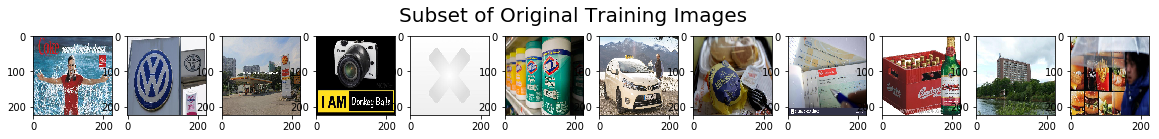

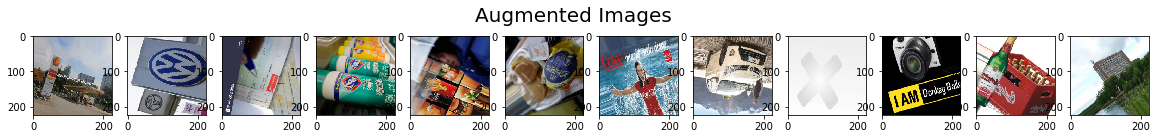

In [15]:
import matplotlib.pyplot as plt

# take subset of training data
train_tensors_subset = train_tensors[:12]

# visualize subset of training data
fig = plt.figure(figsize=(20,2))
for i in range(0, len(train_tensors_subset)):
    ax = fig.add_subplot(1, 12, i+1)
    ax.imshow(train_tensors_subset[i])
fig.suptitle('Subset of Original Training Images', fontsize=20)
plt.show()

# visualize augmented images
fig = plt.figure(figsize=(20,2))
for x_batch in datagen_train.flow(train_tensors_subset, batch_size=12):
    for i in range(0, 12):
        ax = fig.add_subplot(1, 12, i+1)
        ax.imshow(x_batch[i])
    fig.suptitle('Augmented Images', fontsize=20)
    plt.show()
    break;

### Define the Model Architecture

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

model.summary()

### Compile the Model

In [18]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', 
                  metrics=['accuracy'])

### Train the Model

In [21]:
from keras.callbacks import ModelCheckpoint   

batch_size = 32
epochs = 50

# train the model
checkpointer5 = ModelCheckpoint(filepath='saved_keras_models/aug_model.weights.best.hdf5', verbose=1, 
                               save_best_only=True)
model.load_weights('saved_keras_models/weights.best.from_scratch.hdf5')

model.fit_generator(datagen_train.flow(train_tensors, train_targets, batch_size=batch_size),
                    steps_per_epoch=train_tensors.shape[0] // batch_size,
                    epochs=epochs, verbose=1, callbacks=[checkpointer5],
                    validation_data=datagen_valid.flow(val_tensors, val_targets, batch_size=batch_size),
                    validation_steps=val_tensors.shape[0] // batch_size)



Epoch 1/50
188/188 [==============================] - 76s 406ms/step - loss: 3.0432 - acc: 0.2847 - val_loss: 3.2825 - val_acc: 0.2673

Epoch 00001: val_loss improved from inf to 3.28251, saving model to saved_keras_models/aug_model.weights.best.hdf5
Epoch 2/50
188/188 [==============================] - 73s 388ms/step - loss: 2.9861 - acc: 0.2944 - val_loss: 3.3160 - val_acc: 0.2451

Epoch 00002: val_loss did not improve from 3.28251
Epoch 3/50
188/188 [==============================] - 71s 378ms/step - loss: 2.9815 - acc: 0.2955 - val_loss: 3.4162 - val_acc: 0.2282

Epoch 00003: val_loss did not improve from 3.28251
Epoch 4/50
188/188 [==============================] - 72s 381ms/step - loss: 2.9653 - acc: 0.3001 - val_loss: 3.4300 - val_acc: 0.2309

Epoch 00004: val_loss did not improve from 3.28251
Epoch 5/50
188/188 [==============================] - 72s 382ms/step - loss: 2.9467 - acc: 0.2976 - val_loss: 3.2677 - val_acc: 0.2485

Epoch 00005: val_loss improved from 3.28251 to 3.267

In [31]:
batch_size = 32
epochs = 50
checkpointer6 = ModelCheckpoint(filepath='saved_keras_models/weights.best.aug_custom.hdf5', 
                               verbose=1, save_best_only=True)
custom_model.load_weights('saved_keras_models/weights.best.custom.hdf5')
#VGG16_model.fit(train_tensors, train_targets, validation_split=0.2,epochs=10, batch_size=20, callbacks=[checkpointer3], verbose=1)
custom_model.fit_generator(datagen_train.flow(train_tensors, train_targets, batch_size=batch_size),
                    steps_per_epoch=train_tensors.shape[0] // batch_size,
                    epochs=epochs, verbose=1, callbacks=[checkpointer6],
                    validation_data=datagen_valid.flow(val_tensors, val_targets, batch_size=batch_size),
                    validation_steps=val_tensors.shape[0] // batch_size)


Epoch 1/50
188/188 [==============================] - 77s 412ms/step - loss: 3.8840 - acc: 0.1282 - val_loss: 3.6933 - val_acc: 0.1702

Epoch 00001: val_loss improved from inf to 3.69325, saving model to saved_keras_models/weights.best.aug_custom.hdf5
Epoch 2/50
188/188 [==============================] - 76s 404ms/step - loss: 3.8486 - acc: 0.1344 - val_loss: 3.5729 - val_acc: 0.1963

Epoch 00002: val_loss improved from 3.69325 to 3.57295, saving model to saved_keras_models/weights.best.aug_custom.hdf5
Epoch 3/50
188/188 [==============================] - 74s 396ms/step - loss: 3.8051 - acc: 0.1449 - val_loss: 3.5816 - val_acc: 0.2004

Epoch 00003: val_loss did not improve from 3.57295
Epoch 4/50
188/188 [==============================] - 74s 394ms/step - loss: 3.7648 - acc: 0.1519 - val_loss: 3.5116 - val_acc: 0.2187

Epoch 00004: val_loss improved from 3.57295 to 3.51156, saving model to saved_keras_models/weights.best.aug_custom.hdf5
Epoch 5/50
188/188 [=============================

### Load the Model with the Best Validation Accuracy

In [32]:
# load the weights that yielded the best validation accuracy
model.load_weights('saved_keras_models/aug_model.weights.best.hdf5')
custom_model.load_weights('saved_keras_models/weights.best.aug_custom.hdf5')

### Calculate Classification Accuracy on Test Set

In [33]:
# evaluate and print test accuracy
print('\n', 'Test accuracy of the model from scratch:', model.evaluate(test_tensors, test_targets, verbose=0)[1]*100,'%.')
print('\n', 'Test accuracy of the custom model:', custom_model.evaluate(test_tensors, test_targets, verbose=0)[1]*100,'%.')


 Test accuracy of the model from scratch: 30.381760348823644 %.

 Test accuracy of the custom model: 25.609756119683592 %.


In [2]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

### Predict Brand with the Model